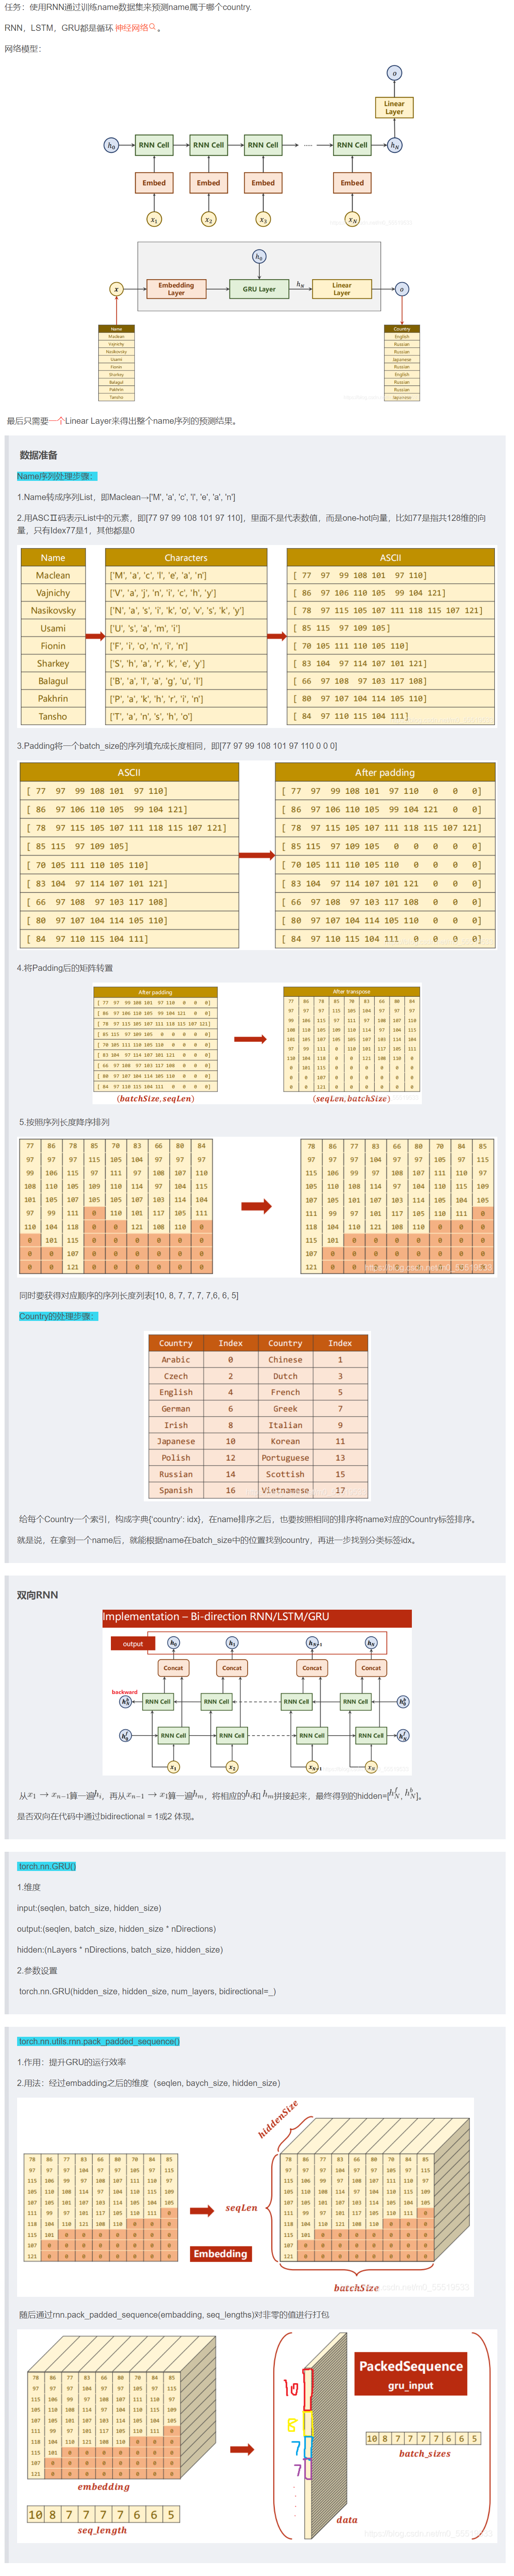

Training for 10 epochs...
 2s] Epoch 1[2560/13374]loss=0.008829536056146026
 4s] Epoch 1[5120/13374]loss=0.00754733202047646
 5s] Epoch 1[7680/13374]loss=0.006852054145808021
 7s] Epoch 1[10240/13374]loss=0.006362564594019205
 9s] Epoch 1[12800/13374]loss=0.006044231811538339
evaluating trained model...
Test set:Accuracy 4510 / 6700  67.31%
 12s] Epoch 2[2560/13374]loss=0.004375038668513298
 13s] Epoch 2[5120/13374]loss=0.004150637495331466
 15s] Epoch 2[7680/13374]loss=0.00401925875339657
 16s] Epoch 2[10240/13374]loss=0.003925575461471454
 18s] Epoch 2[12800/13374]loss=0.0038287945184856654
evaluating trained model...
Test set:Accuracy 4936 / 6700  73.67%
 21s] Epoch 3[2560/13374]loss=0.0032650256063789128
 22s] Epoch 3[5120/13374]loss=0.0032171546365134416
 24s] Epoch 3[7680/13374]loss=0.003175917873159051
 25s] Epoch 3[10240/13374]loss=0.0030947655031923205
 27s] Epoch 3[12800/13374]loss=0.0030488424468785524
evaluating trained model...
Test set:Accuracy 5191 / 6700  77.48%
 30s] E

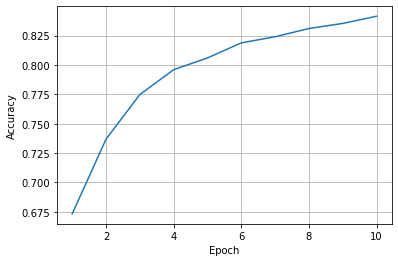

In [5]:
import torch
import gzip
import csv
from torch.utils.data import DataLoader
import numpy as np
from torch.nn.utils import rnn
from torch.utils.data import Dataset
import time
import matplotlib.pyplot as plt
import math
 
#参数初始化
Hidden_size = 100
Batch_size = 256
Num_layers = 2
Num_epoch = 10
Num_chars = 128
use_gpu = False
 
class NameDataset(Dataset):
    '构造数据集'
    def __init__(self, is_train_set=True):
        super(NameDataset, self).__init__()
        filename = 'dataset/names_train.csv.gz' if is_train_set else 'dataset/names_test.csv.gz'
        with gzip.open(filename, 'rt') as f:
            reader = csv.reader(f)
            rows = list(reader) #rows=[(name,country),(name,country),...]
        self.names = [row[0] for row in rows]
        self.len = len(self.names)
        self.countries = [row[1] for row in rows]
        self.country_list = list(sorted(set(self.countries))) #经过去重、排序后得到country列表
        self.country_dict = self.getCountryDict() #用此函数将list转成对应的dict，['country1':idx分类号,'country2':idx分类号,...]
        self.country_num = len(self.country_list)
    def __getitem__(self, index):
        '为了数据集能提供索引访问，返回：索引对应的name字符串,索引对应的country的分类号'
        return self.names[index], self.country_dict[self.countries[index]]
    def __len__(self):
        return self.len
    def getCountryDict(self):
        country_dict = dict()
        for idx, country_name in enumerate(self.country_list, 0):
            country_dict[country_name] = idx
        return country_dict
    def idx2country(self,index):
        return self.country_list[index]
    def getCountryNum(self):
        return self.country_num

#数据准备
train_sets = NameDataset(is_train_set=True)
train_loader = DataLoader(train_sets, batch_size = Batch_size, shuffle=True)
 
test_sets = NameDataset(is_train_set=False)
test_loader = DataLoader(test_sets, batch_size=Batch_size, shuffle=False)
Num_country = train_sets.getCountryNum() #模型最终的分类类别数
 
def create_tensor(tensor):
    if use_gpu:
        device = torch.device("cuda:0")
        tensor = tensor.to(device)
    return tensor
 
def name2list(name):
    "读取名字的每个字符 对应的 的ASC码值，将名字list变成由ASC表示的列表.输出元组：名字的ASC表示 和 名字长度"
    arr = [ord(c) for c in name]
    return arr, len(arr)
 
def make_tensors(names, countries):
    sequences_and_lengths = [name2list(name) for name in names]
    name_sequences = [sl[0] for sl in sequences_and_lengths]
    seq_lengths = torch.LongTensor([sl[1] for sl in sequences_and_lengths])
    countries = countries.long()
 
    # make tensor of name, Batchsize*seqlen
    seq_tensor = torch.zeros(len(name_sequences), seq_lengths.max()).long()
    for idx, (seq, seq_len) in enumerate(zip(name_sequences, seq_lengths), 0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq) #idx对应的位置中，从0到name长度将name填进去
 
    #按照name长度进行排序
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)
    seq_tensor = seq_tensor[perm_idx] #将这两个也按照相同的idx排序
    countries = countries[perm_idx]
 
    return create_tensor(seq_tensor),\
        create_tensor(seq_lengths),\
        create_tensor(countries)
class RNNClassifier(torch.nn.Module):
    '构造RNN分类器模型'
    def __init__(self, input_size, hidden_size, output_size, n_layers=1,bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.directions = 2 if bidirectional else 1
 
        self.embadding = torch.nn.Embedding(input_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=bidirectional)
        self.fc = torch.nn.Linear(hidden_size * self.directions, output_size)
    def _init_hidden(self,batch_size):
        hidden = torch.zeros(self.n_layers * self.directions, batch_size, self.hidden_size)
        return create_tensor(hidden)
    def forward(self,input, seq_lengths):
        'input:所有序列，seq_lengths:每个序列的长度'
        input = input.t() #将input做转置，由batch×seq_len到seq_len×batch
        batch_size = input.size(1) #用它来构造最初的隐层H0
 
        hidden = self._init_hidden(batch_size)
        embadding = self.embadding(input) #shape:(seq_len,batchsize,hiddensize)
 
        # 将序列按照长度降序打包
        gru_input = rnn.pack_padded_sequence(embadding, seq_lengths)
 
        output, hidden = self.gru(gru_input, hidden)
        if self.directions==2:
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1)
        else:
            hidden_cat = hidden[-1]
        fc_output = self.fc(hidden_cat)
        return fc_output

def time_since(since):
    s = time.time()-since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def trainModel():
    total_loss = 0
    for i, (names,countries) in enumerate(train_loader,1):
        inputs, seq_lengths, targets = make_tensors(names,countries)
        output = classifier(inputs, seq_lengths)
        loss = criterion(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if i % 10 == 0:
            print(f'[{time_since(start)}] Epoch {epoch}', end='')
            print(f'[{i * len(inputs)}/{len(train_sets)}]',end='')
            print(f'loss={total_loss / (i * len(inputs))}')
    return total_loss
def testModel():
    correct = 0
    total = len(test_sets)
    print('evaluating trained model...')
    with torch.no_grad():
        for i, (names, countries) in enumerate(test_loader, 1):
            inputs, seq_lengths, targets = make_tensors(names, countries)
            output = classifier(inputs, seq_lengths)
            pred = output.max(dim=1, keepdim=True)[1]
            correct += pred.eq(targets.view_as(pred)).sum().item()
        percent = '%.2f' % (100 * correct / total)
        print(f'Test set:Accuracy {correct} / {total}  {percent}%')
    return correct / total
#参数初始化
 
if __name__=="__main__":
    classifier = RNNClassifier(Num_chars, Hidden_size, Num_country, Num_layers)
    if use_gpu:
        device = torch.device('cuda:0')
        classifier.to(device)
 
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
 
    start = time.time()
    print('Training for %d epochs...' % Num_epoch)
    acc_list = []
    for epoch in range(1,Num_epoch+1):
        trainModel()
        acc = testModel()
        acc_list.append(acc)
 
    epoch = np.arange(1, len(acc_list) + 1, 1)
    acc_list = np.array(acc_list)
    plt.plot(epoch, acc_list)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()